by Shuyan Huang

# Imputing age and gender

## (a) 
Using the survey dataset, we can estimate models to predict gender and age by weight and total income, and then plug in weight and (labor income + capital income) in the BestIncome.txt dataset to impute gender and age. Here we assume that total income = labor income + capital income. We use log-linear model to predict gender and linear model to predict age. Following are our model equations:

$log(\frac{p(female_i)}{1-p(female_i)}) = \alpha_1 + \beta_{11} tot\_inc_i + \beta_{12} wgt_i$

$age_i = \alpha_2 + \beta_{21} tot\_inc_i + \beta_{22} wgt_i$

Where $tot\_inc_i = lab\_inc_i+cap\_inc_i$

## (b)

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
BestIncome = pd.read_csv('BestIncome.txt', header=None)
SurvIncome = pd.read_csv('SurvIncome.txt', header=None)
Best_ary = BestIncome.values
Surv_ary = SurvIncome.values
Surv_female = Surv_ary[:,3]
Surv_age = Surv_ary[:,2]
Surv_x = Surv_ary[:,:2]
Surv_x = sm.add_constant(Surv_x)

model_female = sm.Logit(Surv_female,Surv_x).fit()
model_age = sm.OLS(Surv_age,Surv_x).fit()

Best_x = np.transpose([Best_ary[:,0]+Best_ary[:,1],Best_ary[:,3]])
Best_x = sm.add_constant(Best_x)
Best_female = model_female.predict(Best_x)
Best_female = np.array(list(map(lambda p: 0 if p<0.5 else 1, Best_female)))
Best_age = model_age.predict(Best_x)

Optimization terminated successfully.
         Current function value: 0.036050
         Iterations 11


## (c)

In [2]:
def descripstats(v):
    return {'mean':np.mean(v), 'std':np.std(v), 'min':min(v), 'max':max(v), 'nob':v.shape[0]}

descripstats(Best_age)

{'mean': 44.890828412990999,
 'std': 0.21913910572901438,
 'min': 43.976494892939144,
 'max': 45.703819001557932,
 'nob': 10000}

In [3]:
Best_female = np.array(Best_female)
descripstats(Best_female)

{'mean': 0.4546, 'std': 0.49793457401550256, 'min': 0, 'max': 1, 'nob': 10000}

## (d)

In [4]:
Best_new = np.concatenate((Best_ary, np.transpose([Best_age, Best_female])),axis=1)

In [5]:
np.corrcoef(Best_new)

array([[ 1.        ,  0.99907936,  0.99965113, ...,  0.99633716,
         0.99965026,  0.99348508],
       [ 0.99907936,  1.        ,  0.99986386, ...,  0.99175163,
         0.99986445,  0.98768175],
       [ 0.99965113,  0.99986386,  1.        , ...,  0.99373098,
         0.99999997,  0.99012846],
       ..., 
       [ 0.99633716,  0.99175163,  0.99373098, ...,  1.        ,
         0.99372741,  0.99959121],
       [ 0.99965026,  0.99986445,  0.99999997, ...,  0.99372741,
         1.        ,  0.99012401],
       [ 0.99348508,  0.98768175,  0.99012846, ...,  0.99959121,
         0.99012401,  1.        ]])

# Stationary and data drfit

## (a)

In [25]:
IncomeIntel = pd.read_csv('IncomeIntel.txt', header=None)
IncomeIntel_ary  = IncomeIntel.values
gre_qnt = IncomeIntel_ary[:,1]
salary_p4 = IncomeIntel_ary[:,2]
x =  sm.add_constant(gre_qnt)

model_incomeintel = sm.OLS(salary_p4, x).fit()

model_incomeintel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.263
Model:                            OLS   Adj. R-squared:                  0.262
Method:                 Least Squares   F-statistic:                     356.3
Date:                Mon, 15 Oct 2018   Prob (F-statistic):           3.43e-68
Time:                        12:17:33   Log-Likelihood:                -10673.
No. Observations:                1000   AIC:                         2.135e+04
Df Residuals:                     998   BIC:                         2.136e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       8.954e+04    878.764    101.895      0.000    8.78e+04    9.13e+04
x1           -25.7632      1.365    -18.875      0.000     -28.442     -23.085
==============================================================================
Omnibus:                        9.118   Durbin-Watson:                   1.424
Prob(Omnibus):                  0.010   Jarque-Bera (JB):                9.100
Skew:                           0.230   Prob(JB):                       0.0106
Kurtosis:                       3.077   Cond. No.                     1.71e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.71e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

As can be seen from the summary chart, the estimated coefficients are $\beta_0=89540$ and $\beta_1=-25.7632$, the corresponding standard errors are 878.764 and 1.365

## (b)

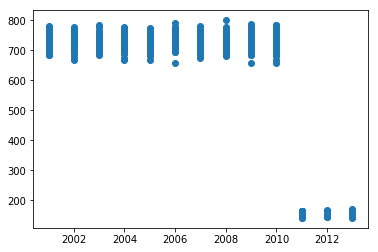

In [7]:
import matplotlib.pyplot as plt
plt.scatter(IncomeIntel_ary[:,0], gre_qnt)

A drift in the GRE quantitative score scale happened in 2011, which will affect the estimated coefficients and the statistical significance of the regression results. A change in variable scale means that the coefficients in the two time period are different. A solution to this problem is to standardize the GRE quantitative score by z score within each year. Instead of using the raw score, we use the relative score, which is not affected by the change of scale.

In [26]:
IncomeIntel.columns = ['grad_year', 'gre_qnt', 'salary_p4']

In [27]:
IncomeIntel['gre_qnt'] = IncomeIntel.groupby('grad_year').transform(lambda x: (x - x.mean()) / x.std())['gre_qnt']

gre_qnt_new = IncomeIntel['gre_qnt'].values

x_new =  sm.add_constant(gre_qnt_new)

## (c)

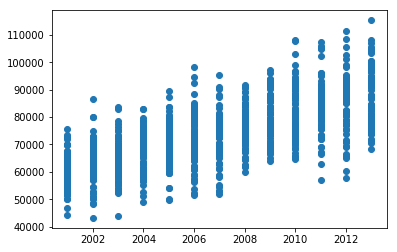

In [10]:
plt.scatter(IncomeIntel_ary[:,0], salary_p4)

In [28]:
 IncomeIntel.groupby('grad_year').mean()

,gre_qnt,salary_p4
grad_year,,
2001.0,-2.145470e-15,60710.709145
2002.0,-5.716207e-15,63034.403163
2003.0,1.826533e-14,64518.742574
2004.0,-9.434012e-15,67773.493082
2005.0,2.462677e-15,70492.592106
2006.0,4.414939e-15,71678.244222
2007.0,-1.016791e-14,72133.654215
2008.0,2.304073e-15,76432.580321
2009.0,-1.651781e-14,79030.629132


From the scatter plot and the chart above, we can see that the mean of the salary over years are changing. To make the salary data stationary over time, we first calculate the average growth rate of the salary $g$, and then standardize the salary by the following equation:

$standardized(salary_{ti}) = salary_{ti} /(1+g)^{t-2001}$

In [38]:
mean_vec = IncomeIntel.groupby('grad_year').mean()['salary_p4'].values

g = np.mean((mean_vec[1:]-mean_vec[:-1])/mean_vec[:-1])

IncomeIntel['salary_p4'] = IncomeIntel['salary_p4']/(1+g)**(IncomeIntel['grad_year']-2001)

salary_p4_new = IncomeIntel['salary_p4']

## (d)

In [39]:
model_incomeintel_new = sm.OLS(salary_p4_new, x_new).fit()

model_incomeintel_new.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              salary_p4   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.4395
Date:                Mon, 15 Oct 2018   Prob (F-statistic):              0.508
Time:                        12:22:38   Log-Likelihood:                -10291.
No. Observations:                1000   AIC:                         2.059e+04
Df Residuals:                     998   BIC:                         2.060e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       6.142e+04    225.711    272.117      0.000     6.1e+04    6.19e+04
x1          -150.6097    227.193     -0.663      0.508    -596.440     295.221
==============================================================================
Omnibus:                        0.776   Durbin-Watson:                   2.025
Prob(Omnibus):                  0.678   Jarque-Bera (JB):                0.687
Skew:                           0.059   Prob(JB):                        0.709
Kurtosis:                       3.049   Cond. No.                         1.01
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

As can be seen from the summary chart, the estimated coefficients are $\beta_0=61420$ and $\beta_1=-150.6097$, the corresponding standard errors are 225.711 and 227.193. $\beta_0$ and its std don't change much but the scale of $\beta_1$ and its std in the new regression is larger than that of the original regression. That's because the standardization we did to the GRE quantitative score decreased the scale of this data by over 100 times, while the standardization we did to the salary didn't change the overall scale of it. Since the coefficient $\beta_1$ is not statistically significant, the regression result gives no evidence that higher intelligence is associated with higher income.

# Assessment of Koissinets and Watts


This paper mainly answers the following research question: What roles do choice homophily and induced homophily play in the emergence of homophily (the observed tendency of people associating with similar people) through the process of individuals in a social network seletively make or break ties with others?

To address this quesiton, the paper explored the data based on the population of 30,396 undergraduate and graduate students, faculty, and staff in a large U.S. university, consisting of 3 datasets: 

1. the logs of e-mail interactions within the university over one academic year, 

2. a database of individual attributes (status, gender, age, department, number of years in the community, etc.),

3. records of course registration

The number of observations is 30396 for personal characteristics, organizational affiliations, and course-related variables. The total number of email interaction is 7,156,162. And the time period of the data is 270 days. In APPENDIX A, we can find a description and definition of all variables.

During the data cleaning process, a potential problem was that the authors included only email messages that were sent to a single recipient, to ensure that the data represent interpersonal communication. This cleared away about 18% of all emails. But in a university context, group emails actually contain a lot of interpersonal communication. For example professors often email their research assistant in a group rather than in person, so that people in the group will know what each other is doing. This might be a unique type of interpersonal communication and eliminating it can lead to loss of a propable source of homophily.

The difficulty of matching the email data to the theoretical construct of "social relationships" lies in the discrete and intermittent feature of email exchanges. It's hard to decide the timing of the formation and dissolution a social link based on a "bursty" time series of email exchanges between two persons. To address this problem, the authors defined the instantaneous strength of a dyad at time t based on the number of email exchanges in time window $\tau$ and sampling period $\delta$. By carefully choosing $\tau$, they decide the maximum time at which a past interaction is assumed to contribute to the current strength of relationship. And $\delta$ determines whether events separated in time will be treated as sequential or as simultaneous with one another.